## Den Anlernprozess steuern: Kapitel 5.2.3
### 1. Daten laden

**Hinweis**: Bei den Daten handelt es sich um konstruierte Daten, die mit Hilfe der Funktion *make_classification* aus Scikit-Learn zusammengestellt wurden. Im Beispiel, das weiter unten beginnt, arbeiten wir mit den abgespeicherten Daten, die innerhalb des Buches verwendet wurden.

Wer selbst Daten zusammenstellen will, kann dies mit der folgenden Syntax:

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np

### Produktion der Daten
X, y = make_classification(n_samples=2000, n_features=10, n_classes=3,
                             n_informative=8, n_redundant=0, 
                             n_clusters_per_class=1, 
                             class_sep=0.65)

### Umwandeln in Data-Frame (falls gewünscht)
df = pd.DataFrame(X)  
df = df.join(pd.DataFrame(np.array(y).reshape(-1,1), columns=['target']))
df.head()

,0,1,2,3,4,5,6,7,8,9,target
0,-3.579097,-0.418446,-0.590195,-1.398272,0.891033,1.902224,1.409482,0.333788,1.144441,1.866713,0
1,-0.361784,1.530435,0.985891,0.634146,-2.386211,2.109656,-2.348815,-1.445031,-0.548551,0.467385,0
2,0.788791,0.357868,1.494238,0.115044,0.333652,-0.896189,0.025605,1.652885,-0.717035,-1.535372,2
3,2.673712,2.120477,1.740581,0.247870,1.026426,4.745017,0.938582,-0.438538,-0.467037,0.253605,1
4,-3.281587,-0.101949,-2.240474,-1.038818,-0.748701,0.215294,2.203428,1.479930,1.321502,-0.507287,0


**Hier werden die Daten aus der Buchvorlage geladen:**

In [2]:
import pandas as pd

data_url=r'https://github.com/tplusone/hanser_ml_zeitreihen/blob/master/Daten/anlernprozess_steuern.csv?raw=true'
df = pd.read_csv(data_url)
df.head()

,0,1,2,3,4,5,6,7,8,9,target
0,-0.280709,-0.059600,0.903313,-1.316667,-0.211657,1.661014,0.614386,-1.661741,-1.236767,1.673179,1
1,-0.991065,-0.457066,0.717418,-0.205517,0.051233,-0.441401,1.145146,0.962219,-0.604699,2.657998,2
2,-0.274415,-4.143297,0.976277,3.525734,-0.615639,-1.275351,-1.976680,-4.283560,-0.102496,-4.236518,0
3,-0.758435,-0.034742,0.211872,-1.471143,-0.841671,-1.463690,3.937600,-0.662916,-0.965079,2.131738,1
4,1.331444,-0.210657,2.110881,0.613726,0.200788,-3.717483,1.880523,-5.730783,1.998385,-3.572608,0


### 2. Daten selektieren und Train-Test-Split durchführen

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=56)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 10), (600, 10), (1400,), (600,))

### 3. Modell aufsetzen

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=20, input_shape=(10,), activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________


### 4. Callbacks zusammenstellen

In [5]:
from tensorflow.keras.callbacks import (EarlyStopping, 
                                        ModelCheckpoint)
from tensorflow.keras.models import load_model 

stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='keras_test_model.h5', 
                            monitor='val_loss', 
                            save_best_only=True)

### 5. Training des Modells unter Anwendung der Callbacks 

In [6]:
epochs = 200
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, 
                     batch_size=batch_size,
                     validation_data=(X_test, y_test), 
                     callbacks=[stopping, checkpoint],
                     verbose=False)
saved_model = load_model('keras_test_model.h5')

### 6. History abfragen und Anlernprozess graphisch darstellen

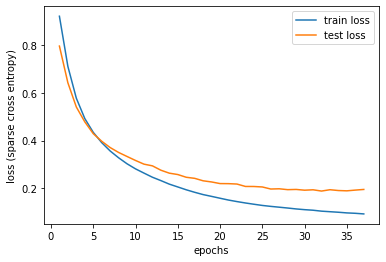

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs_axis = range(1, len(loss)+1)

plt.plot(epochs_axis, loss, label='train loss')
plt.plot(epochs_axis, val_loss, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss (sparse cross entropy)')
plt.legend()

**Hinweis**: Obwohl beim Anlernen 200 Epochen angegeben wurden, wurde der Anlernprozess schon nach 37 Epochen beendet. Das ist die Wirkung der *EarlyStopping*-Klasse, die wir angewiesen haben, das Anlernen abzubrechen wenn bei fünf aufeinanderfolgenden Epochen keine Verbesserung mehr auf den Testdaten erfolgt.
Die Callack-Klasse *ModelCheckpoint* bewirkt dagegen, dass im Hintergrund nur das beste Modell abgespeichert wird. Bei der Definition von "bestes Modell" orientieren wir uns dabei an den Testdaten (vgl. Parameter *monitor*). Dieses Modell wurde unter dem in *filepath* angegebenen Namen abgespeichert. Wenn wir es zur Produktion von Schätzwerten verwenden wollen, können wir es mit der Funktion *load_model* wieder deserialisieren.